In [1]:
import sys
from pathlib import Path

script_dir = Path().resolve()
root_dir = (script_dir.parent)
sys.path.append(str(root_dir))

from endata.data_generator import DataGenerator

/home/fuest/EnData/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Creating a Data Generator and loading a pre-trained model ##

The first step towards creating synthetic time series data is to load a model. In this instance, we will load a pre-trained ACGAN trained on the PecanStreet dataset. In order to do this, you will first need to initialize a data generator.

In [2]:
generator = DataGenerator(model_name="acgan")

The code snippet above initializes an untrained ACGAN. In order to load an appropriate pre-trained model checkpoint, you will need to explicitly load the model checkpoint provided:

In [3]:
generator.load_model(dataset_name="pecanstreet")

Loaded generator state.
Loaded discriminator state.
Loaded generator optimizer state.
Loaded discriminator optimizer state.
Loaded conditioning module state.
Loaded epoch number: 5000
ACGAN models moved to 0.
Loaded Normalizer from /home/fuest/EnData/checkpoints/pecanstreet/normalizer/pecanstreet_dim_1_scale_True_normalizer.pt


/home/fuest/EnData/generator/gan/acgan.py:418: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(
/home/fuest/EnData/generator/normalizer.py:386: FutureW

## Generating synthetic data ##

All pre-trained models in EnData are conditional generative models. This means that the user has to specify the conditions for which the generator generates data. To view the required conditioning variables, each TimeSeriesDataset instance (which includes the dataset classes supported by EnData) has a function that outputs the available conditioning variables and the corresponding integer codes:

In [4]:
conditioning_var_codes = generator.get_conditioning_var_codes()
conditioning_var_codes

{'month': {0: 'January',
  1: 'February',
  2: 'March',
  3: 'April',
  4: 'May',
  5: 'June',
  6: 'July',
  7: 'August',
  8: 'September',
  9: 'October',
  10: 'November',
  11: 'December'},
 'weekday': {0: 'Monday',
  1: 'Tuesday',
  2: 'Wednesday',
  3: 'Thursday',
  4: 'Friday',
  5: 'Saturday',
  6: 'Sunday'},
 'building_type': {0: 'Apartment',
  1: 'Single-Family Home 001 (Master)',
  2: 'Town Home'},
 'has_solar': {0: 'no', 1: 'yes'},
 'car1': {0: 'no', 1: 'yes'},
 'city': {0: 'Austin',
  1: 'Brooktondale',
  2: 'Groton',
  3: 'Ithaca',
  4: 'Lansing',
  5: 'San Diego',
  6: 'Trumansburg'},
 'state': {0: 'California', 1: 'New York', 2: 'Texas'},
 'total_square_footage': {0: '(1070.324, 2010.0]',
  1: '(2010.0, 2945.0]',
  2: '(2945.0, 3880.0]',
  3: '(3880.0, 4815.0]',
  4: '(4815.0, 5750.0]'},
 'house_construction_year': {0: '(1796.7830000000001, 1840.2]',
  1: '(1840.2, 1883.4]',
  2: '(1883.4, 1926.6]',
  3: '(1926.6, 1969.8]',
  4: '(1969.8, 2013.0]'}}

We will now specify the desired conditions in a Python dictionary, and pass those to the data generator, along with the desired number of samples. The samples arg refers to the number of synthetic timeseries with the datasets specified sequence length that the model will generate. It does not refer to the number of measurement values.

In [5]:
cond_vars = {
    "weekday": 1, # Monday
    "month": 2, # January
    "building_type": 0, # Apartment
    "city": 0, # Austin
    "state": 2, # Texas
    "house_construction_year": 3, # between 1969 and 2013
    "total_square_footage": 0, # between 1070 and 2010 sq feet
    "car1": 0, # no ev
    "has_solar": 0, # no solar panels
}

generator.set_model_conditioning_vars(cond_vars)
data = generator.generate(num_samples=2)
data

,weekday,month,building_type,city,state,house_construction_year,total_square_footage,car1,has_solar,timeseries
0,1,2,0,0,2,3,0,0,0,"[[0.105495244], [0.20453241], [0.04291621], [0..."
1,1,2,0,0,2,3,0,0,0,"[[0.10541335], [0.21076262], [0.043198586], [0..."


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from eval.utils import get_hourly_ticks

syn_data = generator.generate(num_samples=100)
syn_data_array = np.array([ts.squeeze() for ts in syn_data["timeseries"]])

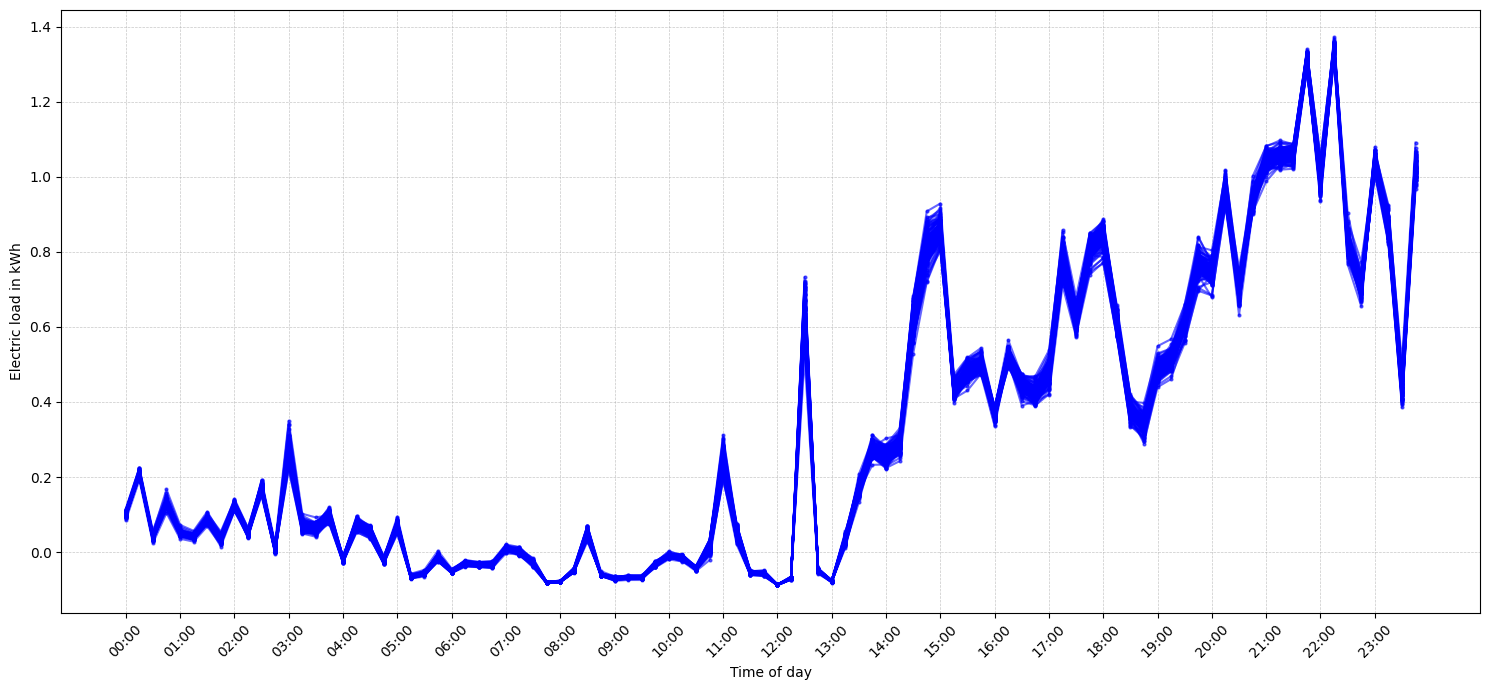

In [7]:
timestamps = pd.date_range(start="00:00", end="23:45", freq="15min")
hourly_positions, hourly_labels = get_hourly_ticks(timestamps)
f = plt.figure(figsize=(15, 7))
for index in range(syn_data_array.shape[0]):
    plt.plot(
        range(len(timestamps)),
        syn_data_array[index],
        color="blue",
        marker="o",
        markersize=2,
        linestyle="-",
        #label="Synthetic time series",
        alpha=0.6,
    )
plt.xlabel("Time of day")
plt.ylabel("Electric load in kWh")
plt.xticks(ticks=hourly_positions, labels=hourly_labels, rotation=45)
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()